In [109]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import linear_model
from sklearn.decomposition import PCA

np.random.seed(0)

In [2]:
# load csv
stats = pd.read_csv('raw.csv')

In [3]:
### draw box plot of rushing yards, all RBs

# yr = 2014
# stats_yr = stats[stats['year']==yr]

#players_list = list(set(stats['full_name']))
#stats_by_player = stats.groupby(['full_name', 'time']).sum()

#stats_list = []

#for player in players_list[:50] :
    #player_stat = stats_by_player.iloc[player]
    #stats_list.append(list(player_stat['rushing_yds']))

#plt.subplots(figsize=(10,20))
#plt.boxplot(stats_list, vert=False)
#plt.yticks(range(1,51), players_list[:50])
#plt.show()

In [78]:
# for all weeks and teams, calculate how many rushing yards (and other RB stats) that team has conceded on average
# creates seperate dataframe home/away conceded stats
# different records for each season -> if you query the first week of the season, this dataframe returns stats for only the first week

team_conc = pd.DataFrame(columns = ['year', 'time', 'team', 'homeaway', 'rushing_att', 'rushing_tds', 'rushing_yds', 'receiving_yds','receiving_tar','receiving_rec','receiving_tds','fumbles_lost'])

yr_range = range(stats.min(0)['year'], stats.max(0)['year']+1)
teams = set(stats['team'])

stats_by_team = stats.groupby(['time','home','away','homeaway']).sum()
stats_by_team = stats_by_team.reset_index()

for yr in yr_range:
    y_stats = stats_by_team.query('year == '+str(yr))
    
    f_wk = y_stats.min(0)['time'] # first and last week of the season
    l_wk = y_stats.max(0)['time']
    
    for wk in range(f_wk, l_wk+1):
        # for each week cumulate up to that week from the beginning of the season
        cumulative_stats = y_stats.query('time >= '+str(f_wk)+'and time <= '+str(wk))
            
        ## code for home conceded stats
        ## rows with homeaway = 0 --> this player is in the away team --> this stat is what the home team conceded to that player
        home_conceded = cumulative_stats.query('homeaway == 0')
        home_conceded.rename(columns={'home':'team'}, inplace=True)
        home_conc_team = home_conceded.groupby(['team']).mean()
        home_conc_team = home_conc_team.reset_index()
        
        home_conc_team['year'] = yr
        home_conc_team['time'] = wk
        home_conc_team['homeaway'] = 1
        
        team_conc = team_conc.append(home_conc_team[['year', 'time', 'team', 'homeaway', 'rushing_att', 'rushing_tds', 'rushing_yds', 'receiving_yds','receiving_tar','receiving_rec','receiving_tds','fumbles_lost']])

        ## code for away conceded stats
        ## rows with homeaway = 1 --> this player is in the home team --> this stat is what the away team conceded to that player
        away_conceded = cumulative_stats.query('homeaway == 1')
        away_conceded.rename(columns={'away':'team'}, inplace=True)
        away_conc_team = away_conceded.groupby(['team']).mean()
        away_conc_team = away_conc_team.reset_index()
        
        away_conc_team['year'] = yr
        away_conc_team['time'] = wk
        away_conc_team['homeaway'] = 0
        
        team_conc = team_conc.append(away_conc_team[['year', 'time', 'team', 'homeaway', 'rushing_att', 'rushing_tds', 'rushing_yds', 'receiving_yds','receiving_tar','receiving_rec','receiving_tds','fumbles_lost']])

team_conc.set_index(['time','team', 'homeaway'], inplace=True)

print team_conc

                    year  rushing_att  rushing_tds  rushing_yds  \
time team homeaway                                                
715  BAL  1         2012     3.000000            0    22.000000   
     CHI  1         2012    16.000000           60   112.000000   
     DEN  1         2012     6.000000            0    -1.000000   
     DET  1         2012     0.000000            0     0.000000   
     GB   1         2012    14.000000            0    69.000000   
     NO   1         2012    28.000000          120    96.000000   
     NYG  1         2012    15.000000            0    32.000000   
     NYJ  1         2012    20.000000            0   110.000000   
     ATL  0         2012    16.000000            0    87.000000   
     CAR  0         2012    24.000000            0    95.000000   
     DAL  0         2012     8.000000            0    31.000000   
     MIA  0         2012    26.000000          120    79.000000   
     NE   0         2012     0.000000            0     0.00000

In [60]:
wk_pl_match = stats.groupby(['full_name','time','homeaway','home','away']).sum()
wk_pl_match = wk_pl_match.reset_index()
wk_pl_match = wk_pl_match.loc[:,['full_name','time','homeaway','home','away']]
wk_pl_match.set_index(['full_name','time'],inplace=True)
print wk_pl_match.head(5)

                      homeaway home away
full_name       time                    
Adrian Peterson 715          1  MIN  JAC
                716          0  IND  MIN
                717          1  MIN   SF
                718          0  DET  MIN
                719          1  MIN  TEN


In [119]:
### generate two sets of training and test data set
# 0-filled: fills non-play weeks with 0s
# avg-filled: fills non-play weeks with the average stats of that player

# set number of past weeks to track
num_wks = 3
stat_list = ['time', 'homeaway', 'rushing_att', 'rushing_tds', 'rushing_yds', 'receiving_yds','receiving_tar','receiving_rec','receiving_tds','fumbles_lost']

players_list = list(set(stats['full_name']))
stats_by_player = stats.groupby(['full_name', 'time']).sum()
stats_by_player = stats_by_player.reset_index()

input_list = []; input_avg_list = []; output_list = []

for player in players_list :   # for every player
    player_stat = stats_by_player.loc[stats_by_player['full_name'] == player].sort_index(by=['time'], ascending=False)
    player_stat = player_stat[stat_list]
    player_avg = [0] + list(player_stat.mean(axis=0))[2:]   # keep avg stat for this player, time and home/away avg is irrelavant
    
    array_stat = player_stat[stat_list].as_matrix()
    
    for i in range(array_stat.shape[0]-1) :
        wk = int(array_stat[i][0])
        
        wanted_input_wks = [str(x) for x in range(wk - num_wks, wk)]   # weeks to look for
        max_row = min(i+num_wks+1, array_stat.shape[0])
        played_wks = [str(array_stat[x][0]) for x in range(i+1, max_row)]   # weeks with play record
        
        if len(set(wanted_input_wks) & set(played_wks)) >= (num_wks * 0.6) :   # only if played in more than 60% of the past n weeks 
            # add this week's stats in the label set
            output_list.append(array_stat[i][1:])   
        
            # add player stats in the data set for the past num_wks
            temp_list = []; temp_avg_list = []
            for j in range(num_wks) :
                if i+j < array_stat.shape[0] :
                    #print array_stat.shape[1]-1, len(stat_list)-1, len(player_avg)
                    if str(array_stat[i+j][0]) in wanted_input_wks :
                        temp_list.extend(array_stat[i+j][1:])   # add in the data set
                        temp_avg_list.extend(array_stat[i+j][1:])
                    else:
                        temp_list.extend([0] * (len(stat_list)-1))   # fill with 0s
                        temp_avg_list.extend(player_avg)   # fill with avg stats
                else:
                    temp_list.extend([0] * (len(stat_list)-1))   # fill with 0s
                    temp_avg_list.extend(player_avg)   # fill with avg stats
                    
            # add opponent team's conceded stats in the data set
            #get player's team and opponent for this week
            ha = int(wk_pl_match.loc[player, wk]['homeaway'])
            
            if ha == 1 : # player's home game
                op = wk_pl_match.loc[player,wk]['away'] # opponent = away team
                
                # retrieve latest opponent team away conceded stats
                for w in range(wk, 0):
                    if (w,op,0) in team_conc.index:
                        op_conc = team_conc.loc[w, op, 0][stat_list[2:]] 
                        op_stats = op_conc.values.tolist()
                        break
                    
                temp_list.extend(op_stats)
                temp_avg_list.extend(op_stats)
                
            else : # player's away game
                op = wk_pl_match.loc[player,wk]['home'] # opponent = home team
                
                for w in range(wk, 0):
                    if (w,op,1) in team_conc.index:
                        op_conc = team_conc.loc[w, op, 1][stat_list[2:]] 
                        op_stats = op_conc.values.tolist()
                        break
                
                temp_list.extend(op_stats)
                temp_avg_list.extend(op_stats)
            
            input_list.append(temp_list)
            input_avg_list.append(temp_avg_list)

# convert to array
data = np.array(input_list)
data_avg = np.array(input_avg_list)
labels = np.array(output_list)

print data.shape, data_avg.shape, labels.shape

(2388L, 35L) (2388L, 35L) (2388L, 9L)


In [120]:
# shuffle and create training and test data set
shuffle = np.random.permutation(range(data.shape[0]))

data,data_avg,labels = data[shuffle],data_avg[shuffle],labels[shuffle]

train_size = int(data.shape[0] * 0.8)

train_data = data[:train_size]
train_avg_data = data_avg[:train_size]
train_labels = labels[:train_size]

test_data = data[train_size:]
test_avg_data = data_avg[train_size:]
test_labels = labels[train_size:]

print 'Train data set: ', train_data.shape, train_labels.shape
print 'Test data set: ' , test_data.shape, test_labels.shape

Train data set:  (1910L, 35L) (1910L, 9L)
Test data set:  (478L, 35L) (478L, 9L)


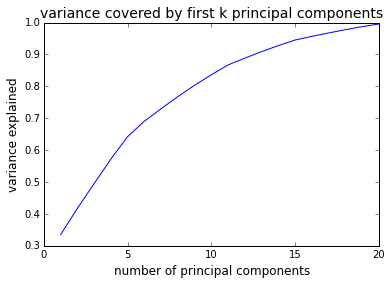

In [115]:
def PCA_proj():
    var=[]
    
    # run PCA for k from 1 to 20 and record the explained variance ratio
    for k in range(1,21):
        pca = PCA(n_components = k)
        pca.fit(train_data)
        var.append(sum(pca.explained_variance_ratio_))
    
    # plot the variance explained
    plt.plot(range(1,21), var)
    plt.xlabel("number of principal components", fontsize=12)
    plt.ylabel("variance explained", fontsize=12)
    plt.title("variance covered by first k principal components", fontsize=14)
    plt.show()
    
PCA_proj()

In [121]:
stat_num = 4
print "stat: %s, # of weeks: %d" % (stat_list[stat_num], num_wks)

# no PCA regression
LR = linear_model.LinearRegression()
LR.fit(train_data, train_labels)
print "Linear Regression(0 filled): RMSE %.2f" % np.sqrt(np.mean((LR.predict(test_data)[:,stat_num] - test_labels[:,stat_num]) ** 2))

LR2 = linear_model.LinearRegression()
LR2.fit(train_avg_data, train_labels)
print "Linear Regression(avg filled): RMSE %.2f" % np.sqrt(np.mean((LR2.predict(test_avg_data)[:,stat_num] - test_labels[:,stat_num]) ** 2))

# PCA with k components
k = 10
pca = PCA(n_components = k)
pca_train = pca.fit_transform(train_data)
pca_test = pca.fit_transform(test_data)

pcaLR = linear_model.LinearRegression()
pcaLR.fit(pca_train, train_labels)
print "PCA with %d components(0 filled): RMSE %.2f" % (k,np.sqrt(np.mean((pcaLR.predict(pca_test)[:,stat_num] - test_labels[:,stat_num]) ** 2)))

pca2 = PCA(n_components = k)
pca_train2 = pca2.fit_transform(train_avg_data)
pca_test2 = pca2.fit_transform(test_avg_data)

pcaLR2 = linear_model.LinearRegression()
pcaLR2.fit(pca_train2, train_labels)
print "PCA with %d components(avg filled): RMSE %.2f" % (k,np.sqrt(np.mean((pcaLR2.predict(pca_test2)[:,stat_num] - test_labels[:,stat_num]) ** 2)))

gbr3 = ensemble.GradientBoostingRegressor(max_depth=3)
gbr3.fit(train_data, train_labels[:,stat_num])
print "GBR with max_depth 3 (0 filled): RMSE %.2f" % np.sqrt(np.mean((gbr3.predict(test_data) - test_labels[:,stat_num]) ** 2))

gbr3a = ensemble.GradientBoostingRegressor(max_depth=3)
gbr3a.fit(train_avg_data, train_labels[:,stat_num])
print "GBR with max_depth 3 (avg filled): RMSE %.2f" % np.sqrt(np.mean((gbr3a.predict(test_avg_data) - test_labels[:,stat_num]) ** 2))

gbr4 = ensemble.GradientBoostingRegressor(max_depth=4)
gbr4.fit(train_data, train_labels[:,stat_num])
print "GBR with max_depth 4 (0 filled): RMSE %.2f" % np.sqrt(np.mean((gbr4.predict(test_data) - test_labels[:,stat_num]) ** 2))

gbr4a = ensemble.GradientBoostingRegressor(max_depth=4)
gbr4a.fit(train_avg_data, train_labels[:,stat_num])
print "GBR with max_depth 4 (avg filled): RMSE %.2f" % np.sqrt(np.mean((gbr4a.predict(test_avg_data) - test_labels[:,stat_num]) ** 2))

gbr5 = ensemble.GradientBoostingRegressor(max_depth=5)
gbr5.fit(train_data, train_labels[:,stat_num])
print "GBR with max_depth 5 (0 filled): RMSE %.2f" % np.sqrt(np.mean((gbr5.predict(test_data) - test_labels[:,stat_num]) ** 2))

gbr5a = ensemble.GradientBoostingRegressor(max_depth=5)
gbr5a.fit(train_avg_data, train_labels[:,stat_num])
print "GBR with max_depth 5 (avg filled): RMSE %.2f" % np.sqrt(np.mean((gbr5a.predict(test_avg_data) - test_labels[:,stat_num]) ** 2))

stat: rushing_yds, # of weeks: 3
Linear Regression(0 filled): RMSE 18.58
Linear Regression(avg filled): RMSE 17.90
PCA with 10 components(0 filled): RMSE 23.04
PCA with 10 components(avg filled): RMSE 25.72
GBR with max_depth 3 (0 filled): RMSE 18.92
GBR with max_depth 3 (avg filled): RMSE 18.16
GBR with max_depth 4 (0 filled): RMSE 19.10
GBR with max_depth 4 (avg filled): RMSE 18.25
GBR with max_depth 5 (0 filled): RMSE 19.17
GBR with max_depth 5 (avg filled): RMSE 18.60
